In [34]:
from modules import *
from functions.tools import *
from functions.TestFuns import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict

from scipy.ndimage import gaussian_filter


---

In [5]:
mnist_data_train = pd.read_csv('datasets/MNIST/mnist_train.csv').set_index('label')
mnist_data_train/=255

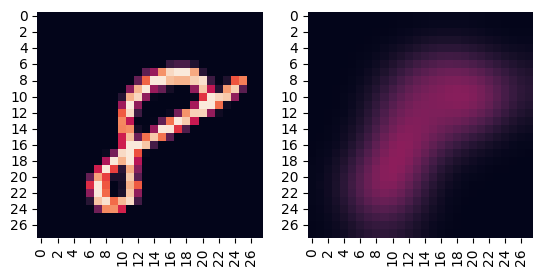

In [51]:
sigma = .25
X = mnist_data_train.values[-1]
# X += np.random.normal(0, sigma, X.shape)

fig, [axl, axr] = plt.subplots(1,2)

im = X.reshape(28,28)
sns.heatmap(im, ax = axl, square=True, cbar = False)


blur_sigma = 3
blurred_im = gaussian_filter(im,blur_sigma)
# blurred_im =( X + np.random.normal(0, .25, X.shape)).reshape(28,28)

sns.heatmap(blurred_im, ax = axr, square=True, cbar = False, vmin = im.min(), vmax = im.max())
plt.show()

In [6]:
selection_of_digits = [1,3,8] 

num_replications = 100
num_samples = 50
num_permutations = 500

sigma = .5




from collections import defaultdict
mmd_tests = defaultdict(list); cke_tests = defaultdict(list)
for rep in tqdm( range(num_replications)):
    for i, x_num in enumerate(selection_of_digits):
        for y_num in selection_of_digits[i:]:
                X = mnist_data_train.loc[x_num].sample(num_samples).values 
                Y = mnist_data_train.loc[y_num].sample(num_samples).values
                X += np.random.normal(0, sigma, X.shape)
                Y += np.random.normal(0, sigma, Y.shape)

                MMD_p_value = MMD_two_sample_test(X,Y)(num_permutations)
                mmd_tests[(x_num, y_num)].append(1 if MMD_p_value < 0.05 else 0)
                mmd_tests[(y_num , x_num)].append(1 if MMD_p_value < 0.05 else 0)

                CKE_p_value = CKE_two_sample_test(X,Y, kappa_K = 1e4)(num_permutations)
                cke_tests[(x_num, y_num)].append(1 if CKE_p_value < 0.05 else 0)
                cke_tests[(y_num , x_num)].append(1 if CKE_p_value < 0.05 else 0)



100%|██████████| 10/10 [02:37<00:00, 15.74s/it]


## Comparing 2 digits

In [ ]:
def run_perturbed_minst_test(x_num, y_num, X, Y, sigma, num_permutations):
    X += np.random.normal(0, sigma, X.shape)
    Y += np.random.normal(0, sigma, Y.shape)
    _mmdtest = 1 if MMD_two_sample_test(X,Y)(num_permutations) < 0.05 else 0
    _cketest = 1 if CKE_two_sample_test(X,Y, kappa_K = 1e4)(num_permutations) < 0.05 else 0
    out =  (('CKE', x_num, y_num, _cketest),  ('MMD', x_num, y_num, _mmdtest))
    return out

In [ ]:
selection_of_digits = [4,9] 
NUM_CORES = 10
subsampled_data = mnist_data_train.loc[selection_of_digits]
num_replications = 100
num_samples = 50
num_permutations = 250

sigma = 1.2

iter_args = [(x_num, y_num, subsampled_data.loc[x_num].sample(num_samples).values, subsampled_data.loc[y_num].sample(num_samples).values, sigma, num_permutations ) 
             for x_num in selection_of_digits for y_num in selection_of_digits for _ in range(num_replications)]
# iter_args = [(selection_of_digits, sigma, num_permutations, num_samples) for _ in range(num_replications)]
results = Parallel(n_jobs=NUM_CORES)(delayed(run_perturbed_minst_test)(*args) for args in tqdm(iter_args))

summary = {'CKE' : defaultdict(list), 'MMD' : defaultdict(list)}
for run in results:
    for line in run:
        summary[line[0]][line[1], line[2]].append(line[3])


100%|██████████| 400/400 [00:47<00:00,  8.40it/s]


Text(0.5, 1.0, 'CKE')

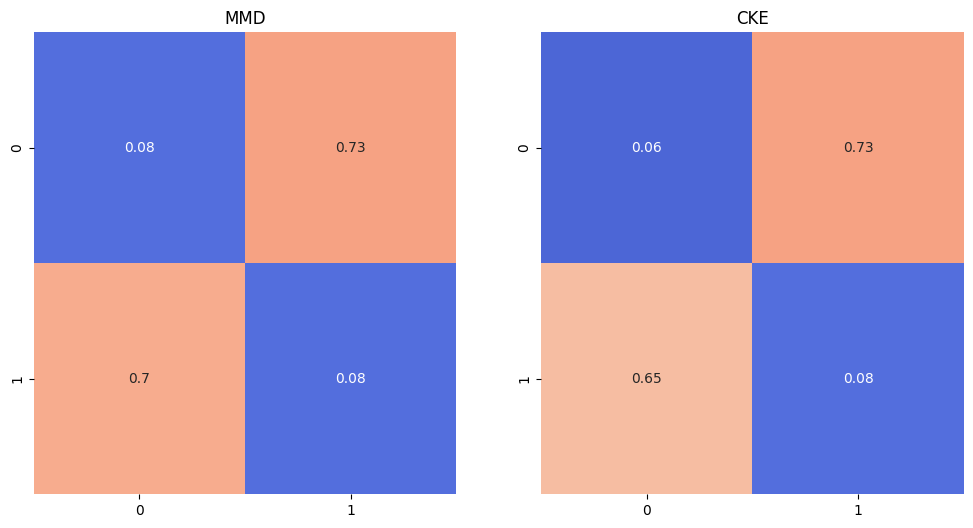

In [ ]:
S = len(selection_of_digits) 
MMD_matrix = np.zeros((S,S)); CKE_matrix = np.zeros((S,S))
for i, x_num in enumerate(selection_of_digits):
    for j, y_num in enumerate(selection_of_digits):
        CKE_matrix[i, j] = sum(summary['CKE'][(x_num, y_num)]) / num_replications;   #CKE_matrix[j, i] = CKE_matrix[i, j]
        MMD_matrix[i, j] = sum(summary['MMD'][(x_num, y_num)]) / num_replications;   #MMD_matrix[j, i] = MMD_matrix[i, j]  


fig, [axMMD, axCKE] = plt.subplots(1, 2, figsize=(12, 6))
vmin = 0; vmax = 1
sns.heatmap(MMD_matrix, annot=True, ax=axMMD, cmap='coolwarm', cbar=False, vmin=vmin, vmax=vmax)
sns.heatmap(CKE_matrix, annot=True, ax=axCKE, cmap='coolwarm', cbar=False, vmin=vmin, vmax=vmax)
axMMD.set_title('MMD')
axCKE.set_title('CKE')

## Comparing 2 sets of digits

### additive noise

In [48]:
def run_perturbed_minst_test(X, Y, sigma, num_permutations, kernel = None):
    X += np.random.normal(0, sigma, X.shape)
    Y += np.random.normal(0, sigma, Y.shape)
    _mmdtest = 1 if MMD_two_sample_test(X,Y)(num_permutations) < 0.05 else 0
    _cketest = 1 if CKE_two_sample_test(X,Y, kappa_K = 1e5, kernel = kernel)(num_permutations) < 0.05 else 0
    out =  (('CKE', _cketest),  ('MMD', _mmdtest))
    return out

In [54]:
group_1 = [9,6,8] 
group_2 = [4,8]

NUM_CORES = 10
num_replications = 100
num_samples = 50
num_permutations = 500

sigma = .75

iter_args = [(mnist_data_train.loc[group_1].sample(num_samples).values, mnist_data_train.loc[group_2].sample(num_samples).values,
               sigma, num_permutations ) for _ in tqdm(range(num_replications))]

print('prepared args!')
results = Parallel(n_jobs=NUM_CORES)(delayed(run_perturbed_minst_test)(*args) for args in tqdm(iter_args))
print('done!')

summary = {'CKE' : list(), 'MMD' : list()}
for run in results:
    for line in run:
        summary[line[0]].append(line[1])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


prepared args!


100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


done!


In [56]:
print('CKE : {}'.format( sum(summary['CKE'])/num_replications))
print('MMD : {}'.format( sum(summary['MMD'])/num_replications))


CKE : 0.55
MMD : 0.63


In [ ]:
# kappa_K = 1e5

# group_1 = [9,6] 
# group_2 = [4,8]

# NUM_CORES = 10
# num_replications = 50
# num_samples = 100
# num_permutations = 500

# sigma = 1.25

# # decent results ! .84 vs .88

# now we need to find a different dataset where we actually do better than MMD

### blur

In [40]:
def run_perturbed_minst_test(X, Y, sigma, num_permutations, kernel = None):
    X  = np.array([ gaussian_filter(_.reshape(28,28), sigma).flatten() for _ in X])
    Y = np.array([ gaussian_filter(_.reshape(28,28), sigma).flatten() for _ in Y])
    _mmdtest = 1 if MMD_two_sample_test(X,Y)(num_permutations) < 0.05 else 0
    _cketest = 1 if CKE_two_sample_test(X,Y, kappa_K = 1e5, kernel = kernel)(num_permutations) < 0.05 else 0
    out =  (('CKE', _cketest),  ('MMD', _mmdtest))
    return out

In [53]:
group_1 = [9,6,8] 
group_2 = [4,8]

NUM_CORES = 10
num_replications = 50
num_samples = 50
num_permutations = 500

sigmas = [0,1,2,3]
outmmd = []
outcke = []
for sigma  in sigmas:
    iter_args = [(mnist_data_train.loc[group_1].sample(num_samples).values, mnist_data_train.loc[group_2].sample(num_samples).values,
                sigma, num_permutations ) for _ in tqdm(range(num_replications))]
    
    print('prepared args!')
    results = Parallel(n_jobs=NUM_CORES)(delayed(run_perturbed_minst_test)(*args) for args in tqdm(iter_args))
    print('done!')

    summary = {'CKE' : list(), 'MMD' : list()}
    for run in results:
        for line in run:
            summary[line[0]].append(line[1])

    outmmd.append( sum(summary['MMD'])/num_replications)
    outcke.append( sum(summary['CKE'])/num_replications)

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


prepared args!


100%|██████████| 50/50 [00:07<00:00,  7.11it/s]


done!


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


prepared args!


100%|██████████| 50/50 [00:07<00:00,  6.39it/s]


done!


100%|██████████| 50/50 [00:16<00:00,  2.94it/s]


prepared args!


100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


done!


100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


prepared args!


100%|██████████| 50/50 [00:07<00:00,  6.58it/s]


done!


In [55]:
# print('CKE : {}'.format( sum(summary['CKE'])/num_replications))
# print('MMD : {}'.format( sum(summary['MMD'])/num_replications))
sigmas = [0,1,2,3]


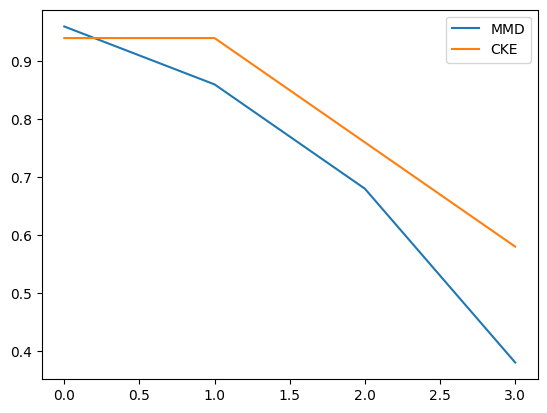

In [56]:

plt.plot(sigmas, outmmd, label = 'MMD')
plt.plot(sigmas, outcke, label = 'CKE')
plt.legend(); plt.show()

Text(0.5, 1.0, 'CKE')

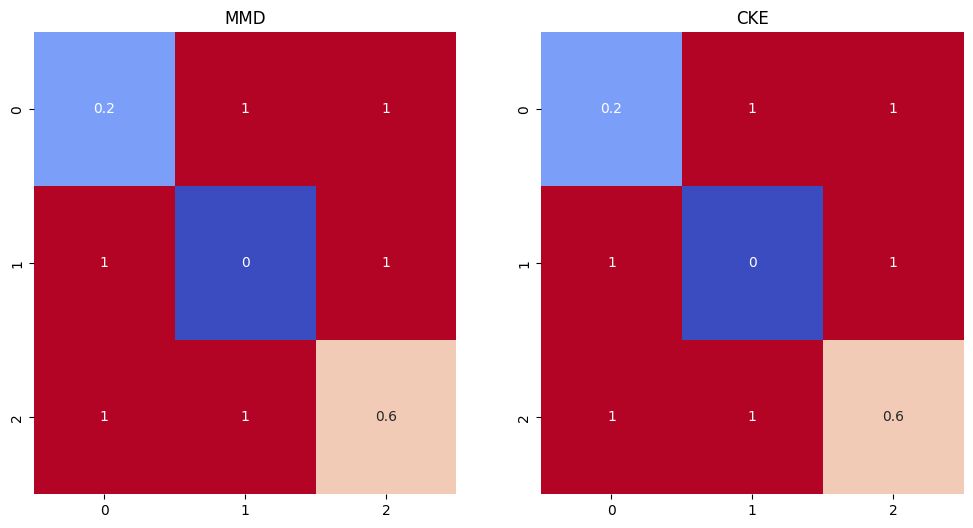

In [7]:
S = len(selection_of_digits) 
MMD_matrix = np.zeros((S,S)); CKE_matrix = np.zeros((S,S))
for i, x_num in enumerate(selection_of_digits):
    for j, y_num in enumerate(selection_of_digits):
        CKE_matrix[i, j] = sum(cke_tests[(x_num, y_num)]) / num_replications;   
        MMD_matrix[i, j] = sum(mmd_tests[(x_num, y_num)]) / num_replications;  


fig, [axMMD, axCKE] = plt.subplots(1, 2, figsize=(12, 6))
vmin = 0; vmax = 1
sns.heatmap(MMD_matrix, annot=True, ax=axMMD, cmap='coolwarm', cbar=False, vmin=vmin, vmax=vmax)
sns.heatmap(CKE_matrix, annot=True, ax=axCKE, cmap='coolwarm', cbar=False, vmin=vmin, vmax=vmax)
axMMD.set_title('MMD')
axCKE.set_title('CKE')

In [9]:
MMD_matrix

array([[0.2, 1. , 1. ],
       [1. , 0. , 1. ],
       [1. , 1. , 0.6]])

In [10]:
CKE_matrix

array([[0.2, 1. , 1. ],
       [1. , 0. , 1. ],
       [1. , 1. , 0.6]])

----

In [50]:
num_replications = 10
num_samples = 50
num_permutations = 1000

from collections import defaultdict
mmd_tests = defaultdict(list); cke_tests = defaultdict(list)
for x_num in tqdm(range(5), position=0):
    for y_num in tqdm(range(x_num, 5), position=1, leave=False):
        for rep in range(num_replications):
            X = mnist_data_train.loc[x_num].sample(num_samples).values
            Y = mnist_data_train.loc[y_num].sample(num_samples).values

            MMD_p_value = MMD_two_sample_test(X,Y)(num_permutations)
            mmd_tests[(x_num, y_num)].append(1 if MMD_p_value < 0.05 else 0)
            mmd_tests[(y_num , x_num)].append(1 if MMD_p_value < 0.05 else 0)

            CKE_p_value = CKE_two_sample_test(X,Y)(num_permutations)
            cke_tests[(x_num, y_num)].append(1 if CKE_p_value < 0.05 else 0)
            cke_tests[(y_num , x_num)].append(1 if CKE_p_value < 0.05 else 0)



MMD_matrix = np.zeros((10, 10)); CKE_matrix = np.zeros((10, 10))
for i, x_num in enumerate(range(10)):
    for j, y_num in enumerate(range(10)):
        CKE_matrix[i, j] = sum(cke_tests[(x_num, y_num)]) / num_replications;   
        MMD_matrix[i, j] = sum(mmd_tests[(x_num, y_num)]) / num_replications;  



fig, [axMMD, axCKE] = plt.subplots(1, 2, figsize=(12, 6))
vmin = 0; vmax = 1
sns.heatmap(MMD_matrix, annot=True, ax=axMMD, cmap='coolwarm', cbar=False, vmin=vmin, vmax=vmax)
sns.heatmap(CKE_matrix, annot=True, ax=axCKE, cmap='coolwarm', cbar=False, vmin=vmin, vmax=vmax)
axMMD.set_title('MMD')
axCKE.set_title('CKE')

 40%|████      | 2/5 [07:34<11:21, 227.16s/it]


KeyboardInterrupt: 

----

100%|██████████| 20/20 [04:34<00:00, 13.72s/it]


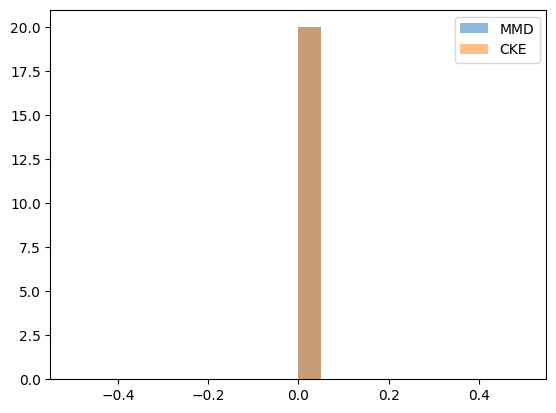

1.0
1.0


In [52]:
num_permutations = 1009
n_samples = 50
mmd_pvals = []; cke_pvals = []
x_num = 4; y_num = 1
# x_num = 9; y_num = 5

nexp = 20
for _ in tqdm(range(nexp)):
    X = mnist_data_train.loc[x_num].sample(n_samples).values
    Y = mnist_data_train.loc[y_num].sample(n_samples).values
    
    mmd_pvals.append(MMD_two_sample_test(X,Y)(num_permutations))
    cke_pvals.append(CKE_two_sample_test(X,Y, kappa_K = 1000)(num_permutations))

plt.hist(mmd_pvals, bins = 20, alpha = 0.5, label = 'MMD')
plt.hist(cke_pvals, bins = 20, alpha = 0.5, label = 'CKE')
plt.legend()
plt.show()

print(sum([_<.05 for _ in mmd_pvals]) / len(mmd_pvals))
print(sum([_<.05 for _ in cke_pvals]) / len(cke_pvals))


In [18]:
bc_control = pd.DataFrame(data['data'][data['target'] == 0])
bc_study = pd.DataFrame(data['data'][data['target'] == 1])

num_permutations = 500
n_samples = 50
mmd_pvals = []; cke_pvals = []

for _ in tqdm(range(10)):
    X = bc_control.sample(n_samples).values
    Y =bc_study.sample(n_samples).values
    mmd_pvals.append(MMD_two_sample_test(X,Y)(num_permutations))
    cke_pvals.append(CKE_two_sample_test(X,Y, kappa_K = 1000)(num_permutations))

print('MMD : {}'.format(np.mean(mmd_pvals)))
print('CKE : {}'.format(np.mean(cke_pvals)))


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]
